## Choose example here

In [1]:
# Name of test to be plotted
test = 'Example4'

if test == 'Example2':
    model = 'TwoBreakdownTypes' # Can choose "TwoBreakdownTypes" or "OnlyPartialBreakdowns"
    mode = 'VP'
    name = test + '_' + model + '_' + mode
elif test == 'Example4':
    model = 'OnlyPartialBreakdowns' # Can choose "TwoBreakdownTypes" or "OnlyPartialBreakdowns"
    mode = 'VP'
    name = test + '_' + model + '_' + mode
else:
    print('Invalid test specified.')

# Set to true to save figures
save_to_file = True

## Import Packages

In [2]:
## General purpose
import numpy as np
import os
import numpy.ma as ma
import string
import csv

## Plotting-specific
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import matplotlib.ticker as ticker

## Interpolation
from scipy.interpolate import RectBivariateSpline

## Set plotting defaults
titletextsize = 18
labeltextsize = 14
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('savefig', dpi = 300)
n_levels = 11

figwidth  = 12
figheight = 3

## Define function for formatting colorbar in scientific notation
##      From here: https://stackoverflow.com/questions/25983218/scientific-notation-colorbar-in-matplotlib
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

## Define function for formatting colorbar with 3 significant figures
##      Based on code here: https://stackoverflow.com/questions/3410976/how-to-round-a-number-to-significant-figures-in-python
def fmt3(x, pos):
    if len('{:.3g}'.format(x)) != 4:
        if x < 10:
            return r'{:.2f}'.format(float('{:.3g}'.format(x)))
        else:
            return r'{:.1f}'.format(float('{:.3g}'.format(x)))
    else:
        return r'{:g}'.format(float('{:.3g}'.format(x)))

## Define function for setting axis size
##      From here: https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
## Define function for reading variables from file
def read_from_file(suffix):
    temp = np.fromfile(data_location + suffix, fdtype)
    temp = temp.reshape(nx,ny)
    return ma.masked_array(temp, mask=not_domain)
    
## Define output directory for saving figures to file
output_directory = name
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

## Read in data from file

In [3]:
data_location = '../output/' + name
fdtype = np.dtype('f8')

## Read in grid sizes
gridsizes = np.fromfile(data_location + '_GridSizes', 'int32')
nx = gridsizes[0]
ny = gridsizes[1]

## Read in step sizes
stepsizes = np.fromfile(data_location + '_StepSizes', fdtype)
dx = stepsizes[0]
dy = stepsizes[1]

## Define grid
X = np.arange(0,nx)*dx
Y = np.arange(0,ny)*dy

## Read in domain
domain = np.fromfile(data_location + '_Domain',np.dtype('bool'))
domain = domain.reshape(nx,ny)
not_domain = 1-domain

## Read in depots
depots = np.fromfile(data_location + '_Depots',np.dtype('bool'))
depots = depots.reshape(nx,ny)

## Read in goal
goals = np.fromfile(data_location + '_Goal',np.dtype('bool'))
goals = goals.reshape(nx,ny)

X_grid, Y_grid = np.meshgrid(X,Y)
depots_y = X_grid[depots]
depots_x = Y_grid[depots]
goals_y = X_grid[goals]
goals_x = Y_grid[goals]

## Read in arrays
u_1   = read_from_file('_WorkingCost')

if model == 'TwoBreakdownTypes' or model == 'OnlyTotalBreakdowns':
    u_r   = read_from_file('_RepairCost')
if model == 'TwoBreakdownTypes' or model == 'OnlyPartialBreakdowns':
    u_2   = read_from_file('_DamagedCost')

if test == "Example4":
    elevation = np.genfromtxt("../data/Ex4_elevation.csv", delimiter = ",")

## Compute Optimal Trajectories

### Function Definitions

In [4]:
# Set up path tracing parameters
nTheta = 360
stepSize = np.sqrt(dx**2 + dy**2)/10
threshold = 1.0e-8

# Set up interpolation of the v and w value functions 
getTravelValue = RectBivariateSpline(X, Y, u_1, kx = 1, ky = 1)
getRepairValue = RectBivariateSpline(X, Y, u_2, kx = 1, ky = 1)

# Extract list of goal and depot points
xGoals = []
yGoals = []
xDepots = []
yDepots = []

for i in range(nx):
    for j in range(ny):
        if goals[i][j] == True:
            xGoals.append(X[i])
            yGoals.append(Y[j])
        if depots[i][j] == True:
            xDepots.append(X[i])
            yDepots.append(Y[j])
            
xDepots = xDepots + xGoals
yDepots = yDepots + yGoals

# Define distance helper function
def distance(x, y, target):
    minDist = 1e8
    if target == 'goal':
        for (targetx,targety) in zip(xGoals, yGoals):
            curDist = (targetx - x)**2 + (targety - y)**2
            if curDist < minDist:
                minDist = curDist
    elif target == 'depot':
        for (targetx,targety) in zip(xDepots, yDepots):
            curDist = (targetx - x)**2 + (targety - y)**2
            if curDist < minDist:
                minDist = curDist
    else:
        print('Invalid target.')
        return False
    
    return minDist
        

In [5]:
# Define path tracing function

def trace_path(initialX, initialY, target):
    if target == 'goal':
        getValue = getTravelValue
    elif target == 'depot':
        getValue = getRepairValue
    else:
        print('Invalid target.')
        return False
    
    currentX = initialX
    currentY = initialY
    xPath = [currentX]
    yPath = [currentY]
    currentValue = getValue(currentX, currentY)
    
    while distance(currentX, currentY, target) >= stepSize and len(xPath) < 1e5:
        ## Grid search over directions
        bestX = -1
        bestY = -1
        minValue = 1e8
        for i in range(nTheta):
            theta = 2*np.pi*i/nTheta
            newX = currentX + np.cos(theta)*stepSize
            newY = currentY + np.sin(theta)*stepSize
            newValue = getValue(newX,newY)
            if (newValue < minValue):
                minValue = newValue
                bestX = newX
                bestY = newY
        
        ## Add new point to path
        xPath.append(bestX)
        yPath.append(bestY)
        currentX = bestX
        currentY = bestY
        currentValue = minValue
        
    return xPath, yPath

# Plotting

In [6]:
# choose some example paths to trace

if test == 'Example2':
    x0 = 0.1
    y0 = 0.4
    BDTimes = [0.1, 0.6] 
elif test == 'Example4':
    x0 = 0.99
    y0 = 0.1
    BDTimes = [0.1, 0.5]

# Compute trajectories
print('Computing Path...')
travelPathX, travelPathY = trace_path(x0, y0, 'goal')
print('Done.')

kBD = [round(len(travelPathX)*t) for t in BDTimes]
print('Computing first breakdown path...')
repairPath1X, repairPath1Y = trace_path(travelPathX[kBD[0]], travelPathY[kBD[0]], 'depot')
print('Done.')
print('Computing second breakdown path...')
repairPath2X, repairPath2Y = trace_path(travelPathX[kBD[1]], travelPathY[kBD[1]], 'depot')
print('Done.')

if test == 'Example2' and model == 'TwoBreakdownTypes':
    repairTimes = [0.3]
    kRepair = [round(len(repairPath1X)*t) for t in repairTimes]
    print('Computing first repaired path...')
    newPath1X, newPath1Y = trace_path(repairPath1X[kRepair[0]], repairPath1Y[kRepair[0]], 'goal')
    print('Done.')

Computing Path...
Done.
Computing first breakdown path...
Done.
Computing second breakdown path...
Done.


In [7]:
if test == 'Example4':
    # Generate additional trajectories to overlay over the value functions
    workingY0s = [0.95, 0.55, 0.45]
    workingX0s = [0.7, 0.99, 0.7] 
    workingPathXDict = {}
    workingPathYDict = {}
    
    for i in range(len(workingY0s)):
        ## Compute trajectories
        print('Computing Path...')
        workingPathXDict[i], workingPathYDict[i] = trace_path(workingX0s[i], workingY0s[i], 'goal')
        print('Done.')
    
    damagedY0s = [0.55]
    damagedX0s = [travelPathX[kBD[1]]]
    damagedPathXDict = {}
    damagedPathYDict = {} 
    
    for i in range(len(damagedY0s)):
        ## Compute trajectories
        print('Computing Path...')
        damagedPathXDict[i], damagedPathYDict[i] = trace_path(damagedX0s[i], damagedY0s[i], 'depot')
        print('Done.')

Computing Path...
Done.
Computing Path...
Done.
Computing Path...
Done.
Computing Path...
Done.


### Broken Cost $u_2(x,y)$

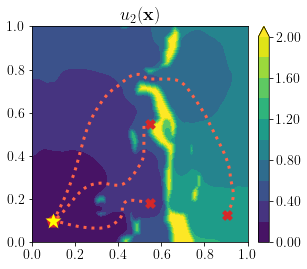

In [8]:
%matplotlib inline
fig, ax = plt.subplots()

## Contour plot
# Set limits
u_2_min = np.min(u_2)
if u_2_min < 0.001:
        u_2_min = 0
if test == 'Example4':
    u_2_max = 2
else:
    u_2_max = np.max(u_2)

u_2_levels = np.linspace(u_2_min, u_2_max, n_levels);
if test == 'Example4':
    im = ax.contourf(X, Y, np.transpose(u_2), u_2_levels, extend = 'max')
else:
    im = ax.contourf(X, Y, np.transpose(u_2), u_2_levels)

# Plot depot and target locations
plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, markerfacecolor = 'tab:red', marker = 'p', markeredgecolor = 'none')
plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = 'yellow', marker = '*', markeredgecolor = 'none')
ax.tick_params(labelsize = labeltextsize)

# Set plot title
if test == 'Example2':
    if model == 'TwoBreakdownTypes':
        ax.set_title('$u_2(\mathbf{x})\,$   $\,(\lambda_1 = 1, \lambda_2 = 3$)', fontsize=titletextsize)
    else:
        ax.set_title('$u_2(\mathbf{x})\,$   $\,(\lambda_1 = \lambda_2 = 0$)', fontsize=titletextsize)
else:
    ax.set_title('$u_2(\mathbf{x})$', fontsize=titletextsize)  


# Plot optimal trajectories
if test == 'Example4':
    ax.plot(repairPath1X, repairPath1Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    ax.plot(repairPath2X, repairPath2Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    ax.plot(damagedPathXDict[0], damagedPathYDict[0], 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
#     ax.plot(damagedPathXDict[1], damagedPathYDict[1], 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    
    plt.scatter(travelPathX[kBD[0]], travelPathY[kBD[0]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
    plt.scatter(travelPathX[kBD[1]], travelPathY[kBD[1]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
    plt.scatter(damagedX0s[0], damagedY0s[0], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
#     plt.scatter(damagedX0s[1], damagedY0s[1], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
else:
#     ax.plot(travelPathX, travelPathY,'k',linewidth=3, zorder=1)
    ax.plot(repairPath1X, repairPath1Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    ax.plot(repairPath2X, repairPath2Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    
    plt.scatter(travelPathX[kBD[0]], travelPathY[kBD[0]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
    plt.scatter(travelPathX[kBD[1]], travelPathY[kBD[1]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
    
## Add colorbar and fix aspect ratio
plt.xlim([0,1])
plt.ylim([0,1])
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cax.tick_params(labelsize=labeltextsize)
if u_2_max >= 100:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
else:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
ax.set_aspect(1)
set_size(figwidth, figheight)

plt.show()
if save_to_file:
    fig.savefig(output_directory + '/' + name + '_DamagedCostTrajectory.png', bbox_inches='tight')

### Working Cost $u_1(x,y)$

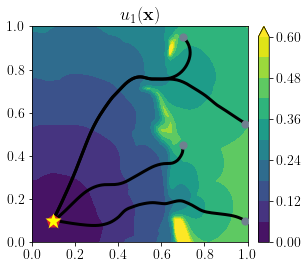

In [9]:
%matplotlib inline
fig, ax = plt.subplots()


## Set levels for colorbar
u_1_min = np.min(u_1)
if u_1_min < 0.001:
        u_1_min = 0
if test == 'Example4':
    u_1_max = 0.6
    
else:
    u_1_max = np.max(u_1)
u_1_levels = np.linspace(u_1_min,u_1_max,n_levels)

## Contour plot
if test == 'Example4':
    im = ax.contourf(X, Y, np.transpose(u_1), u_1_levels, extend = 'max')
else:
    im = ax.contourf(X, Y, np.transpose(u_1), u_1_levels)

# Plot goal and depot locations
plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, markerfacecolor = 'tab:red', marker = 'p', markeredgecolor = 'none', zorder=3)
plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = 'yellow', marker = '*', markeredgecolor = 'none', zorder=3)
ax.tick_params(labelsize = labeltextsize)

if test == 'Example2':
    if model == 'TwoBreakdownTypes':
        ax.set_title('$u_1(\mathbf{x})\,$   $\,(\lambda_1 = 1, \lambda_2 = 3$)', fontsize=titletextsize)
    else:
        ax.set_title('$u_1(\mathbf{x})\,$   $\,(\lambda_1 = \lambda_2 = 0$)', fontsize=titletextsize)
else:
    ax.set_title('$u_1(\mathbf{x})$', fontsize=titletextsize)


# Plot optimal trajectories
if test == 'Example4':
    ax.plot(travelPathX, travelPathY,'k',linewidth=3, zorder=1)
    ax.plot(workingPathXDict[0], workingPathYDict[0], 'k', linewidth=3, zorder=2)
    ax.plot(workingPathXDict[1], workingPathYDict[1], 'k', linewidth=3, zorder=2)
    ax.plot(workingPathXDict[2], workingPathYDict[2], 'k', linewidth=3, zorder=2)
    
    plt.plot(x0, y0,  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)
    plt.plot(workingX0s[0], workingY0s[0],  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)
    plt.plot(workingX0s[1], workingY0s[1],  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)
    plt.plot(workingX0s[2], workingY0s[2],  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)

else:
    ax.plot(travelPathX, travelPathY,'k',linewidth=3, zorder=1)
    ax.plot(repairPath1X, repairPath1Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    ax.plot(repairPath2X, repairPath2Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=2)
    
    plt.plot(x0, y0,  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)
    plt.scatter(travelPathX[kBD[0]], travelPathY[kBD[0]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)
    plt.scatter(travelPathX[kBD[1]], travelPathY[kBD[1]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=3)


# Plot trajectory after repair
if test == 'Example2' and model == 'TwoBreakdownTypes':
    plt.plot(repairPath1X[kRepair[0]], repairPath1Y[kRepair[0]], markersize = 0.4*titletextsize, markerfacecolor='lawngreen', markeredgecolor = 'lawngreen', marker = 'o', zorder=3)
    ax.plot(newPath1X, newPath1Y,'k',linewidth=3, zorder=1, linestyle='dashed')

    
## Add colorbar and fix aspect ratio
plt.xlim([0,1])
plt.ylim([0,1])
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cax.tick_params(labelsize=labeltextsize)
if u_1_max >= 100:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
else:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
    ax.set_aspect(1)
set_size(figwidth, figheight)

plt.show()
if save_to_file:
    fig.savefig(output_directory + '/' + name + '_WorkingCostTrajectory.png', bbox_inches='tight')


## Elevation Plots

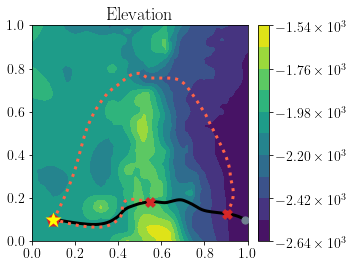

In [10]:
if test == 'Example4':
    %matplotlib inline
    fig, ax = plt.subplots()

    ## Set levels for colorbar
    ele_min = np.min(elevation)
    ele_max = np.max(elevation)

    ele_levels = np.linspace(ele_min,ele_max,n_levels)

    ## Contour plot
    im = ax.contourf(X, Y, elevation, ele_levels)

    # Plot depot and goal locations
    plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, markerfacecolor = 'tab:red', marker = 'p', markeredgecolor = 'none')
    plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, markerfacecolor = 'yellow', marker = '*', markeredgecolor = 'none')


    # Plot optimal trajectories
    ax.plot(travelPathX, travelPathY,'k',linewidth=3, zorder=1)
    ax.plot(repairPath1X, repairPath1Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=1)
    ax.plot(repairPath2X, repairPath2Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=1)
    ## Uncomment to plot extra mode 2 trajectories
    # ax.plot(repairPath3X, repairPath3Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=1)
    # ax.plot(repairPath4X, repairPath4Y, 'tomato', linestyle = 'dotted', linewidth=3, zorder=1)

    plt.plot(x0, y0,  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)
    plt.scatter(travelPathX[kBD[0]], travelPathY[kBD[0]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=2)
    plt.scatter(travelPathX[kBD[1]], travelPathY[kBD[1]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=2)
    ## Uncomment to plot extra mode 1 trajectories
    # plt.scatter(travelPathX[k[2]], travelPathY[k[2]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=2)
    # plt.scatter(travelPathX[k[3]], travelPathY[k[3]], s = 5*titletextsize, c='tab:red', marker = 'X', zorder=2)

    ## Add colorbar and fix aspect ratio
    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cax.tick_params(labelsize=labeltextsize)
    ax.tick_params(labelsize = labeltextsize)
    ax.set_title('Elevation', fontsize=titletextsize)
    if abs(ele_max) >= 100:
        cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
    else:
        cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
    ax.set_aspect(1)
    set_size(1/3*figwidth, figheight)

    plt.show()
    if save_to_file:
        fig.savefig(output_directory + '/' + name + '_ElevationTrajectory.png', bbox_inches='tight')

## Example 3

In [23]:
test = 'Example3'
model = 'OnlyPartialBreakdowns'
mode = 'VP'

# choose breadown rates to look at
bdrs = [0, 3, 5]

travelPathXDict = {}
travelPathYDict = {}
repairPathXDict = {}
repairPathYDict = {}

## Read in grid sizes
gridsizes = np.fromfile(data_location + '_GridSizes', 'int32')
nx = gridsizes[0]
ny = gridsizes[1]

## Read in step sizes
stepsizes = np.fromfile(data_location + '_StepSizes', fdtype)
dx = stepsizes[0]
dy = stepsizes[1]

## Define grid
X = np.arange(0,nx)*dx
Y = np.arange(0,ny)*dy

## Read in domain
domain = np.fromfile(data_location + '_Domain',np.dtype('bool'))
domain = domain.reshape(nx,ny)
not_domain = 1-domain

## Read in depots
depots = np.fromfile(data_location + '_Depots',np.dtype('bool'))
depots = depots.reshape(nx,ny)

## Read in goal
goals = np.fromfile(data_location + '_Goal',np.dtype('bool'))
goals = goals.reshape(nx,ny)

X_grid, Y_grid = np.meshgrid(X,Y)
depots_y = X_grid[depots]
depots_x = Y_grid[depots]
goals_y = X_grid[goals]
goals_x = Y_grid[goals]

# get paths
for bdr in bdrs:
    # read in value functions
    name = test + '_' + model + '_' + mode + '_' + str(bdr)
    data_location = '../output/' + name
    u_1   = read_from_file('_WorkingCost')
    u_2   = read_from_file('_DamagedCost')

    # Set up interpolation of the v and w value functions 
    getTravelValue = RectBivariateSpline(X, Y, u_1, kx = 1, ky = 1)
    getRepairValue = RectBivariateSpline(X, Y, u_2, kx = 1, ky = 1)

    # trace paths
    x0 = 0.1
    y0 = 0.1
    BDTime = 0.5

    ## compute trajectories
    print('Computing Path...')
    travelPathXDict[bdr], travelPathYDict[bdr] = trace_path(x0, y0, 'goal')
    print('Done.')

# choose value function for background
bdr = 3
name = test + '_' + model + '_' + mode + '_' + str(bdr)
data_location = '../output/' + name

## Define output directory for saving figures to file
output_directory = name
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    
u_1   = read_from_file('_WorkingCost')
u_2   = read_from_file('_DamagedCost')

Computing Path...
Done.
Computing Path...
Done.
Computing Path...
Done.


## Plotting

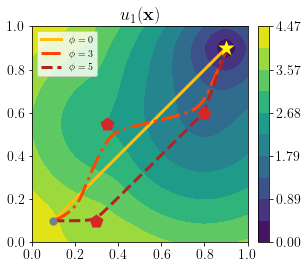

In [26]:
%matplotlib inline
fig, ax = plt.subplots()


## Set levels for colorbar
u_1_min = np.min(u_1)
if u_1_min < 0.001:
        u_1_min = 0
u_1_max = np.max(u_1)
u_1_levels = np.linspace(u_1_min,u_1_max,n_levels)

## Contour plot of expected Profit P
im = ax.contourf(X, Y, np.transpose(u_1), u_1_levels)
ax.tick_params(labelsize = labeltextsize)
ax.set_title('$u_1(\mathbf{x})$', fontsize=titletextsize)
plt.xlim([0,1])
plt.ylim([0,1])

# Plot optimal trajectories
linestyles = ['solid', 'dashdot', 'dashed', 'dotted']
colors = ['#ffbe0f', 'orangered', 'firebrick']

for i in range(len(bdrs)):
    bdr = bdrs[i]
    ax.plot(travelPathXDict[bdr], travelPathYDict[bdr],colors[i], linestyle=linestyles[i], linewidth=3, zorder=1)

plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, linestyle = 'None', markerfacecolor = 'tab:red', marker = 'p', markeredgecolor = 'none')
plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, linestyle = 'None', markerfacecolor = 'yellow', marker = '*', markeredgecolor = 'none')
plt.plot(x0, y0,  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)

## Add colorbar and fix aspect ratio
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cax.tick_params(labelsize=labeltextsize)
if u_1_max >= 100:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
else:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
ax.set_aspect(1)
set_size(figwidth, figheight)

ax.legend([r'$\phi = 0$', r'$\phi = 3$', r'$\phi = 5$'])

plt.show()
if save_to_file:
    fig.savefig(output_directory + '/' + name + '_WorkingCostTrajectory.png', bbox_inches='tight')

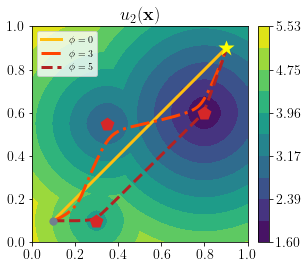

In [27]:
%matplotlib inline
fig, ax = plt.subplots()

## Contour plot
u_2_min = np.min(u_2)
if u_2_min < 0.001:
    u_2_min = 0
u_2_max = np.max(u_2)
u_2_levels = np.linspace(u_2_min, u_2_max, n_levels);

im = ax.contourf(X, Y, np.transpose(u_2), u_2_levels)
ax.tick_params(labelsize = labeltextsize)
ax.set_title('$u_2(\mathbf{x})$', fontsize=titletextsize)
plt.xlim([0,1])
plt.ylim([0,1])

# Plot optimal trajectories
colors = ['#ffbe0f', 'orangered', 'firebrick']
linestyles = ['solid', 'dashdot', 'dashed', 'dotted']
for i in range(len(bdrs)):
    bdr = bdrs[i]
    ax.plot(travelPathXDict[bdr], travelPathYDict[bdr],colors[i], linestyle=linestyles[i], linewidth=3, zorder=1)

plt.plot(depots_x, depots_y, markersize = 0.8*titletextsize, linestyle='None', markerfacecolor = 'tab:red', marker = 'p', markeredgecolor = 'none')
plt.plot(goals_x, goals_y, markersize = 0.9*titletextsize, linestyle='None', markerfacecolor = 'yellow', marker = '*', markeredgecolor = 'none')
plt.plot(x0, y0,  markersize = 0.4*titletextsize, markerfacecolor='slategray', markeredgecolor = 'slategray', marker = 'o', zorder=3)


## Add colorbar and fix aspect ratio
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cax.tick_params(labelsize=labeltextsize)
if u_2_max >= 100:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt)) # Force scientific notation for colorbar
else:
    cb = fig.colorbar(im, cax, format=ticker.FuncFormatter(fmt3)) # No scientific notation for colorbar
ax.set_aspect(1)
set_size(figwidth, figheight)

ax.legend([r'$\phi = 0$', r'$\phi = 3$', r'$\phi = 5$'])

plt.show()
if save_to_file:
    fig.savefig(output_directory + '/' + name + '_DamagedCostTrajectory.png', bbox_inches='tight')